In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from lib.fno import FNO1d
from lib.utils import relative_l2_error
from lib.dataset import PDEDataset

In [3]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [4]:
modes = 16
width = 64
layers = 2
fno = FNO1d(modes, width, layers)  # model

# load model weights
fno.load_state_dict(torch.load("models/fno_model.pth", weights_only=True))

<All keys matched successfully>

In [5]:
BATCH_SIZE = 10

In [6]:
test_data = PDEDataset("data/test_sol.npy")
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for input, target in progress_bar:
        
        prediction = fno(input).squeeze(-1)

        loss = torch.sum(relative_l2_error(prediction, target))
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(test_data)

test_relative_l2

100%|██████████| 13/13 [00:00<00:00, 279.55it/s]


0.027804919402115047

In [8]:
# pick 10 random samples and draw prediction and target
samples = DataLoader(test_data, batch_size=1, shuffle=True)

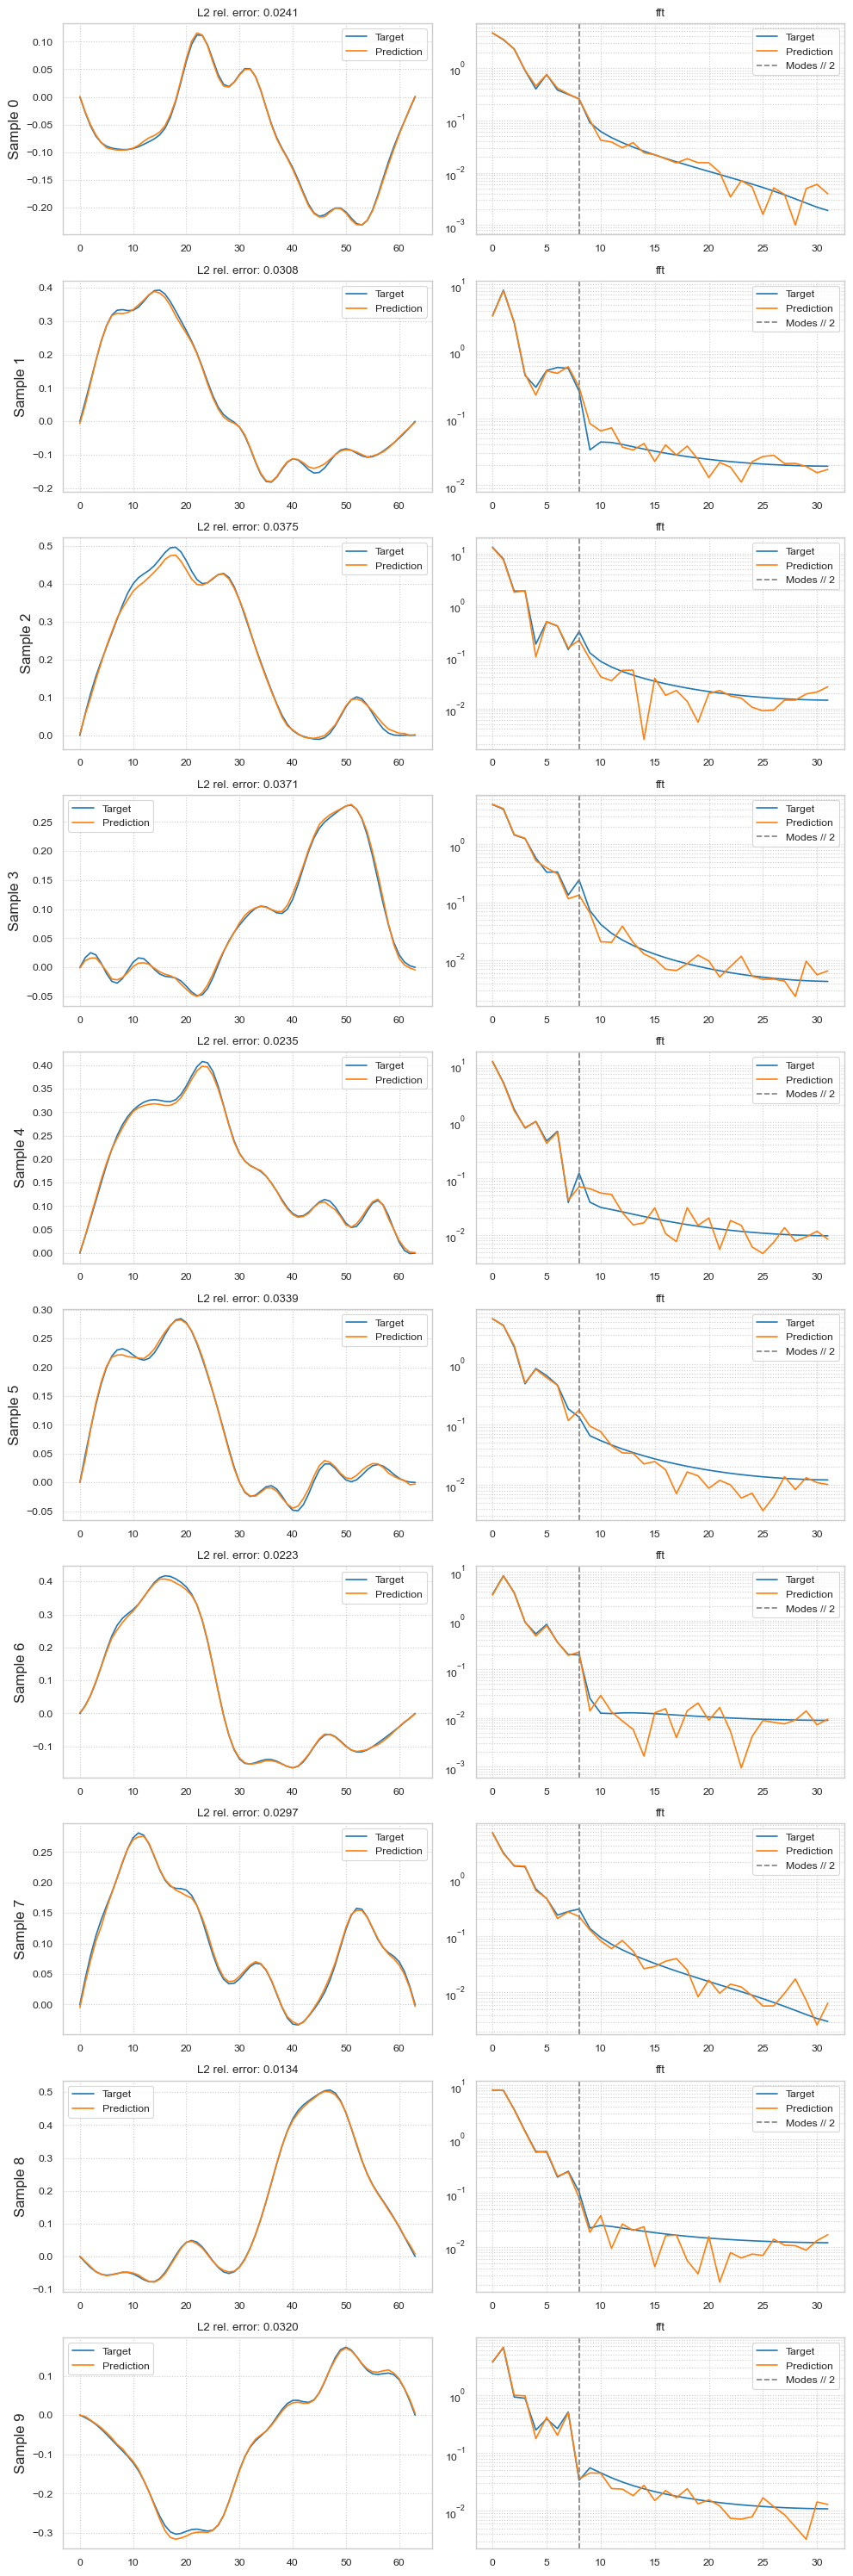

In [9]:
fig, axs = plt.subplots(10, 2, figsize=(10, 30))

fno.eval()
with torch.no_grad():
    for i, (ax_rows, sample) in enumerate(zip(axs, samples)):
        input, target = sample

        prediction = fno(input).squeeze(-1)

        re_l2_error = relative_l2_error(prediction, target).item()

        ax = ax_rows[0]

        ax.set_ylabel(f"Sample {i}", fontsize=12)

        ax.plot(
            # sample[0, :, 1].numpy(),
            target.squeeze(0).numpy(),
            label="Target",
        )
        ax.plot(
            # sample[0, :, 1].numpy(),
            prediction.squeeze(0).numpy(),
            label="Prediction",
        )

        ax.set_title(f"L2 rel. error: {re_l2_error:.4f}")

        ax.legend()
        ax.grid(True, which="both", ls=":")

        ax = ax_rows[1]
        ax.set_yscale("log")

        # plot freqiencies spectrum of target and prediction
        target_fft = np.fft.fft(target.squeeze(0).numpy())
        prediction_fft = np.fft.fft(prediction.squeeze(0).numpy())

        ax.plot(
            np.abs(target_fft)[: len(target_fft) // 2],
            label="Target",
        )

        ax.plot(
            np.abs(prediction_fft)[: len(prediction_fft) // 2],
            label="Prediction",
        )

        ax.axvline(modes // 2, color="gray", ls="--", label="Modes // 2")

        ax.set_title("fft")
        ax.legend()
        ax.grid(True, which="both", ls=":")

plt.tight_layout()
plt.show()

In [10]:
def eval_model_on_data_set(model: torch.nn.Module, data_loader: DataLoader):
    model.eval()
    total_relative_error = []

    with torch.no_grad():
        for input, target in data_loader:
            pred = model(input).squeeze(-1)
            total_relative_error += relative_l2_error(pred, target).numpy().tolist()
        
    return total_relative_error

Resolution: 32, Average relative L2 error: 0.1070
Resolution: 64, Average relative L2 error: 0.0288
Resolution: 96, Average relative L2 error: 0.0396
Resolution: 128, Average relative L2 error: 0.0479
512
512


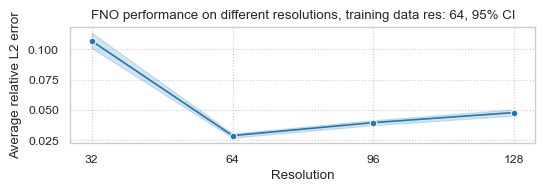

In [11]:
errors = {
    "l2_error": [],
    "resolution": [],
}

for i, n in enumerate([32, 64, 96, 128]):
    test_data = PDEDataset(f"data/test_sol_res_{n}.npy")
    test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

    test_relative_l2 = eval_model_on_data_set(fno, test_data_loader)

    average = np.mean(test_relative_l2)

    print(f"Resolution: {n}, Average relative L2 error: {average:.4f}")

    errors["l2_error"] += test_relative_l2
    errors["resolution"] += [n] * len(test_data)

print(len(errors["l2_error"]))
print(len(errors["resolution"]))

plt.figure(figsize=(6, 1.5))
sns.lineplot(x="resolution", y="l2_error", data=errors, markers=True, marker="o")

plt.xticks([32, 64, 96, 128])

plt.xlabel("Resolution")
plt.ylabel("Average relative L2 error")
plt.title("FNO performance on different resolutions, training data res: 64, 95% CI")
plt.grid(True, which="both", ls=":")
plt.show()


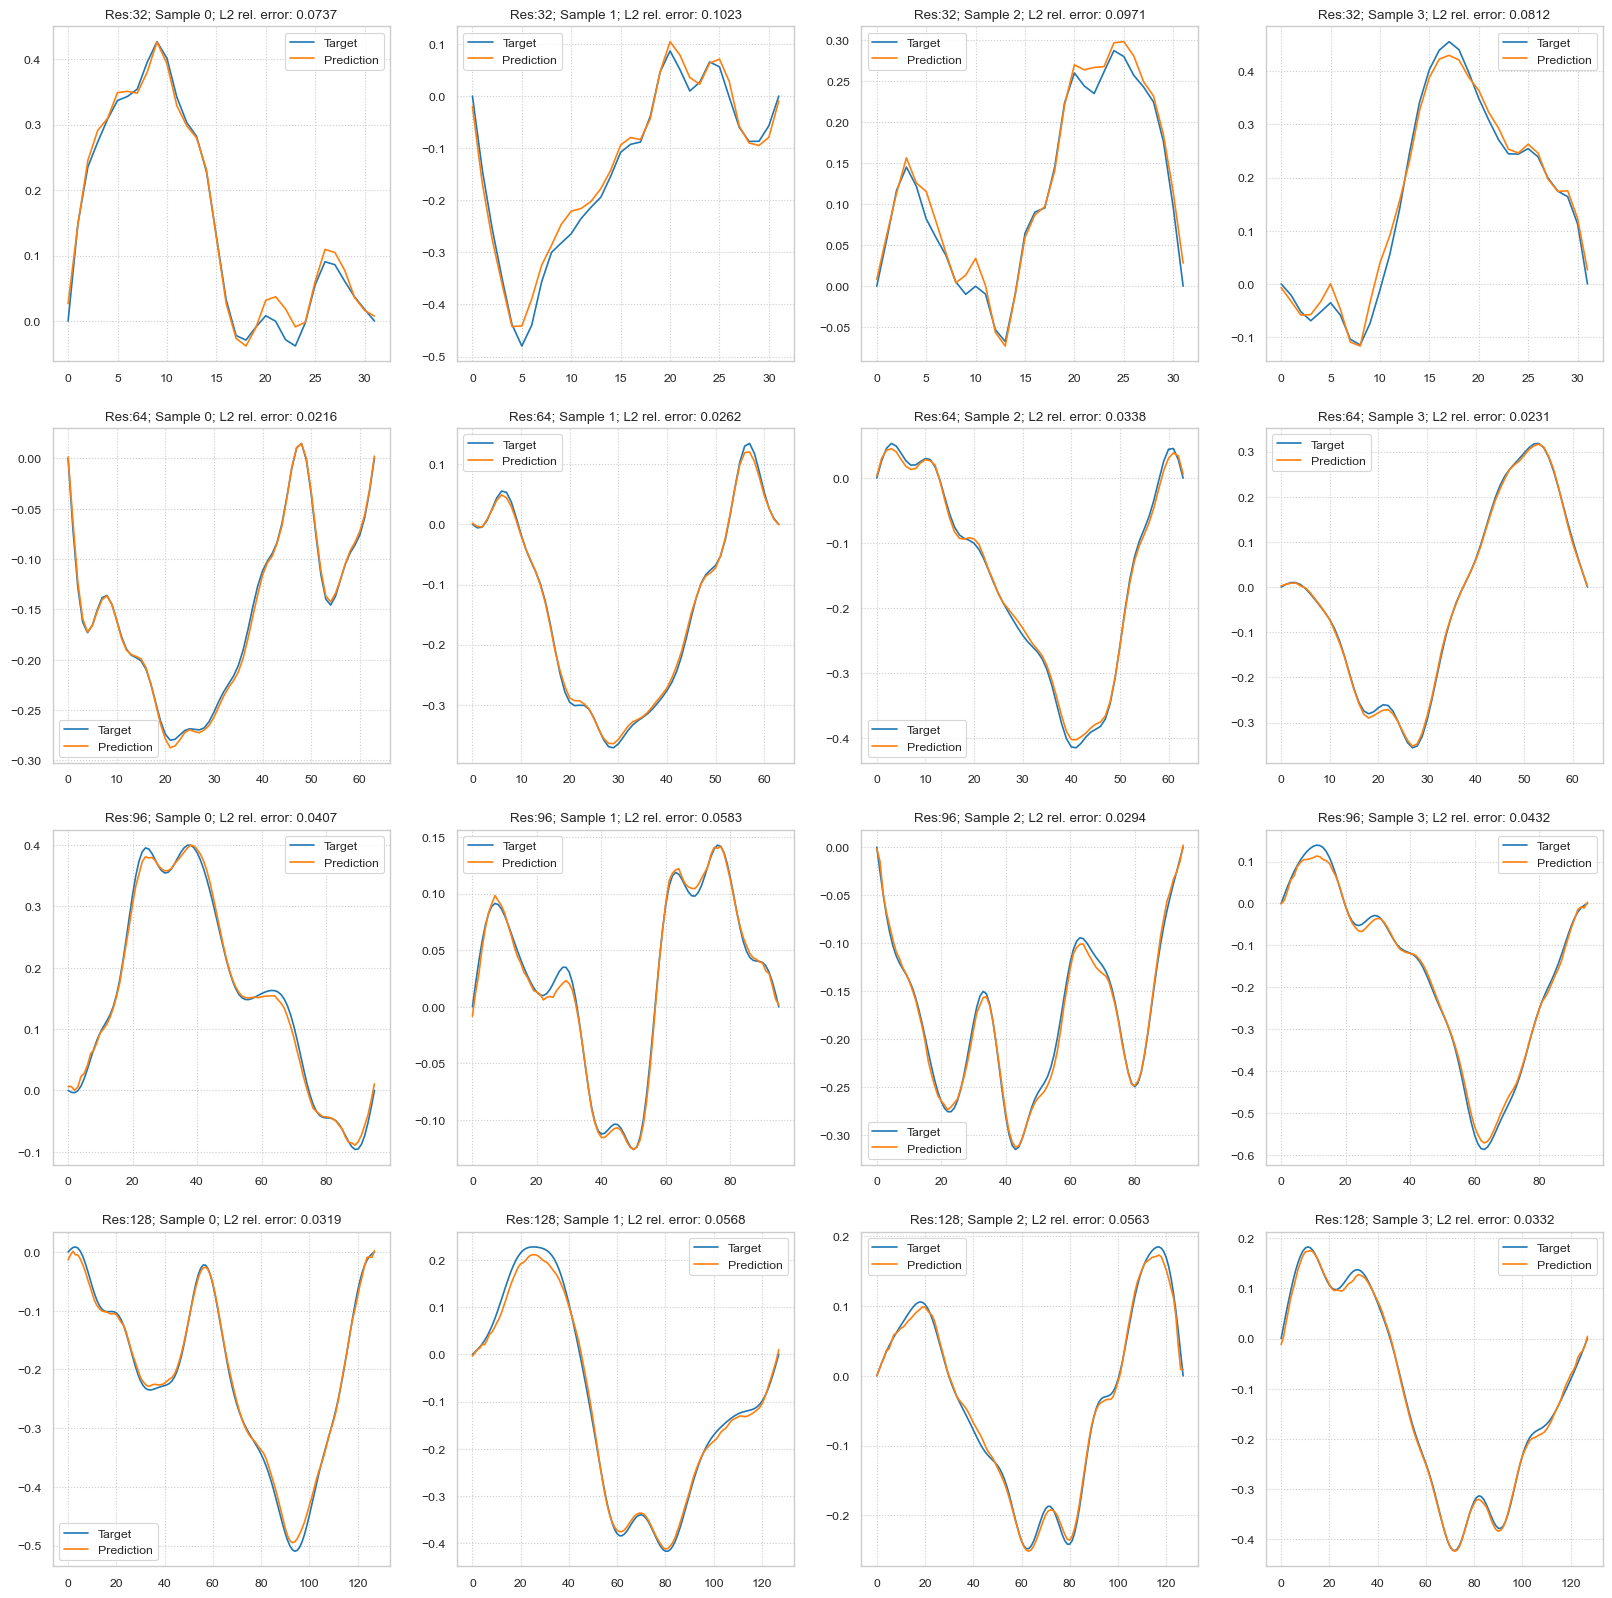

In [12]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, n in enumerate([32, 64, 96, 128]):
    test_data = PDEDataset(f"data/test_sol_res_{n}.npy")
    test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

    # pick N samples
    N = 4
    samples = DataLoader(test_data, batch_size=1, shuffle=True)

    with torch.no_grad():
        for j, sample in enumerate(samples):
            input, target = sample

            prediction = fno(input).squeeze(-1)

            re_l2_error = relative_l2_error(prediction, target).item()

            ax = axs[i, j]

            ax.plot(
                target.squeeze(0).numpy(),
                label="Target",
            )
            ax.plot(
                prediction.squeeze(0).numpy(),
                label="Prediction",
            )
            ax.set_title(f"Res:{n}; Sample {j}; L2 rel. error: {re_l2_error:.4f}")

            ax.legend()
            ax.grid(True, which="both", ls=":")
            if j == N - 1:
                break